# Abstract

This blog post will explore the use of machine learning to classify Palmer Penguins based on their physical measurements and location. Beginning with data preprocessing and exploration cleaned up and contextualized our analysis for the subsequent model training. We employed logistic regression and selected features in a repeatable and cross-validated manor achieving an 100% testing accuracy when classifying the penguins. This result shows the effectiveness of using culmen length, culmen depth, and island location as predictive features. The blog post also lays out provides a tradition workflow to use machine learning on ecological datasets.
---

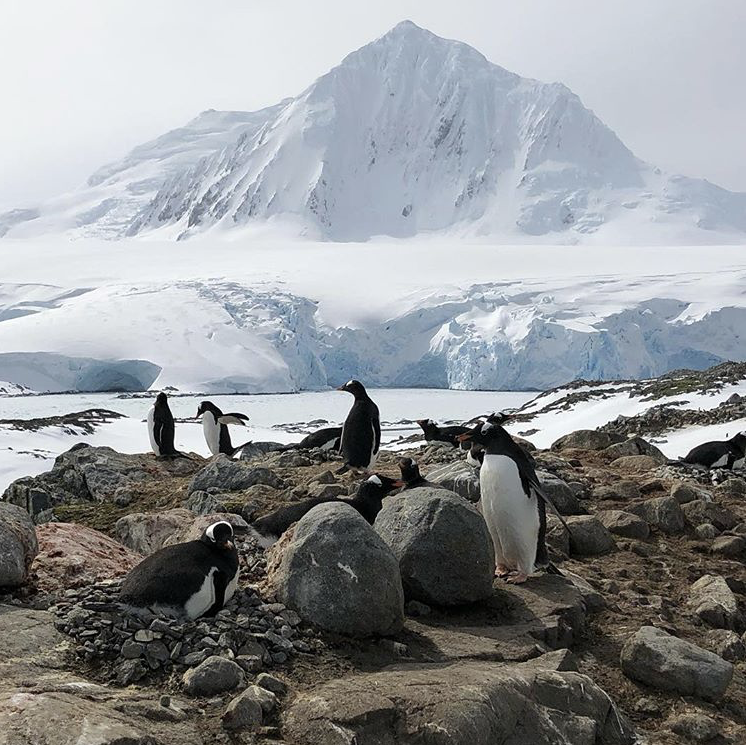

In [129]:
from IPython.display import Image, display
display(Image(filename='palmer_station.png'))

*[Image Source](https://detroitzooblog.org/tag/palmer-station/)*

# Data

This code block handles our **Training Data Acquisition** from the Palmer Penguins data set. This collection holds data for three types of Penguins living across three islands. There is a mix of quantitative measurements and qualitative observations.

In [130]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

Here is a first look at our raw data:

In [131]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


We first extract the species name for data presentation purposed, drop unnecessary columns, remove missing values, and filter out any invalid data. We return the processed feature set (X_train) and target species labels (y_train).

In [132]:
from sklearn.preprocessing import LabelEncoder

# Mapping full species names exclude scientific names
train["Species"] = train["Species"].str.split().str.get(0)

le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

This is what our formatted feature set looks like:

In [133]:
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


# Data Exploration
The pair plot below gives us a introduces us to our data with a wide array of visualizations. These pairwise relationships are a great starting point to begin understanding the nature of the data.

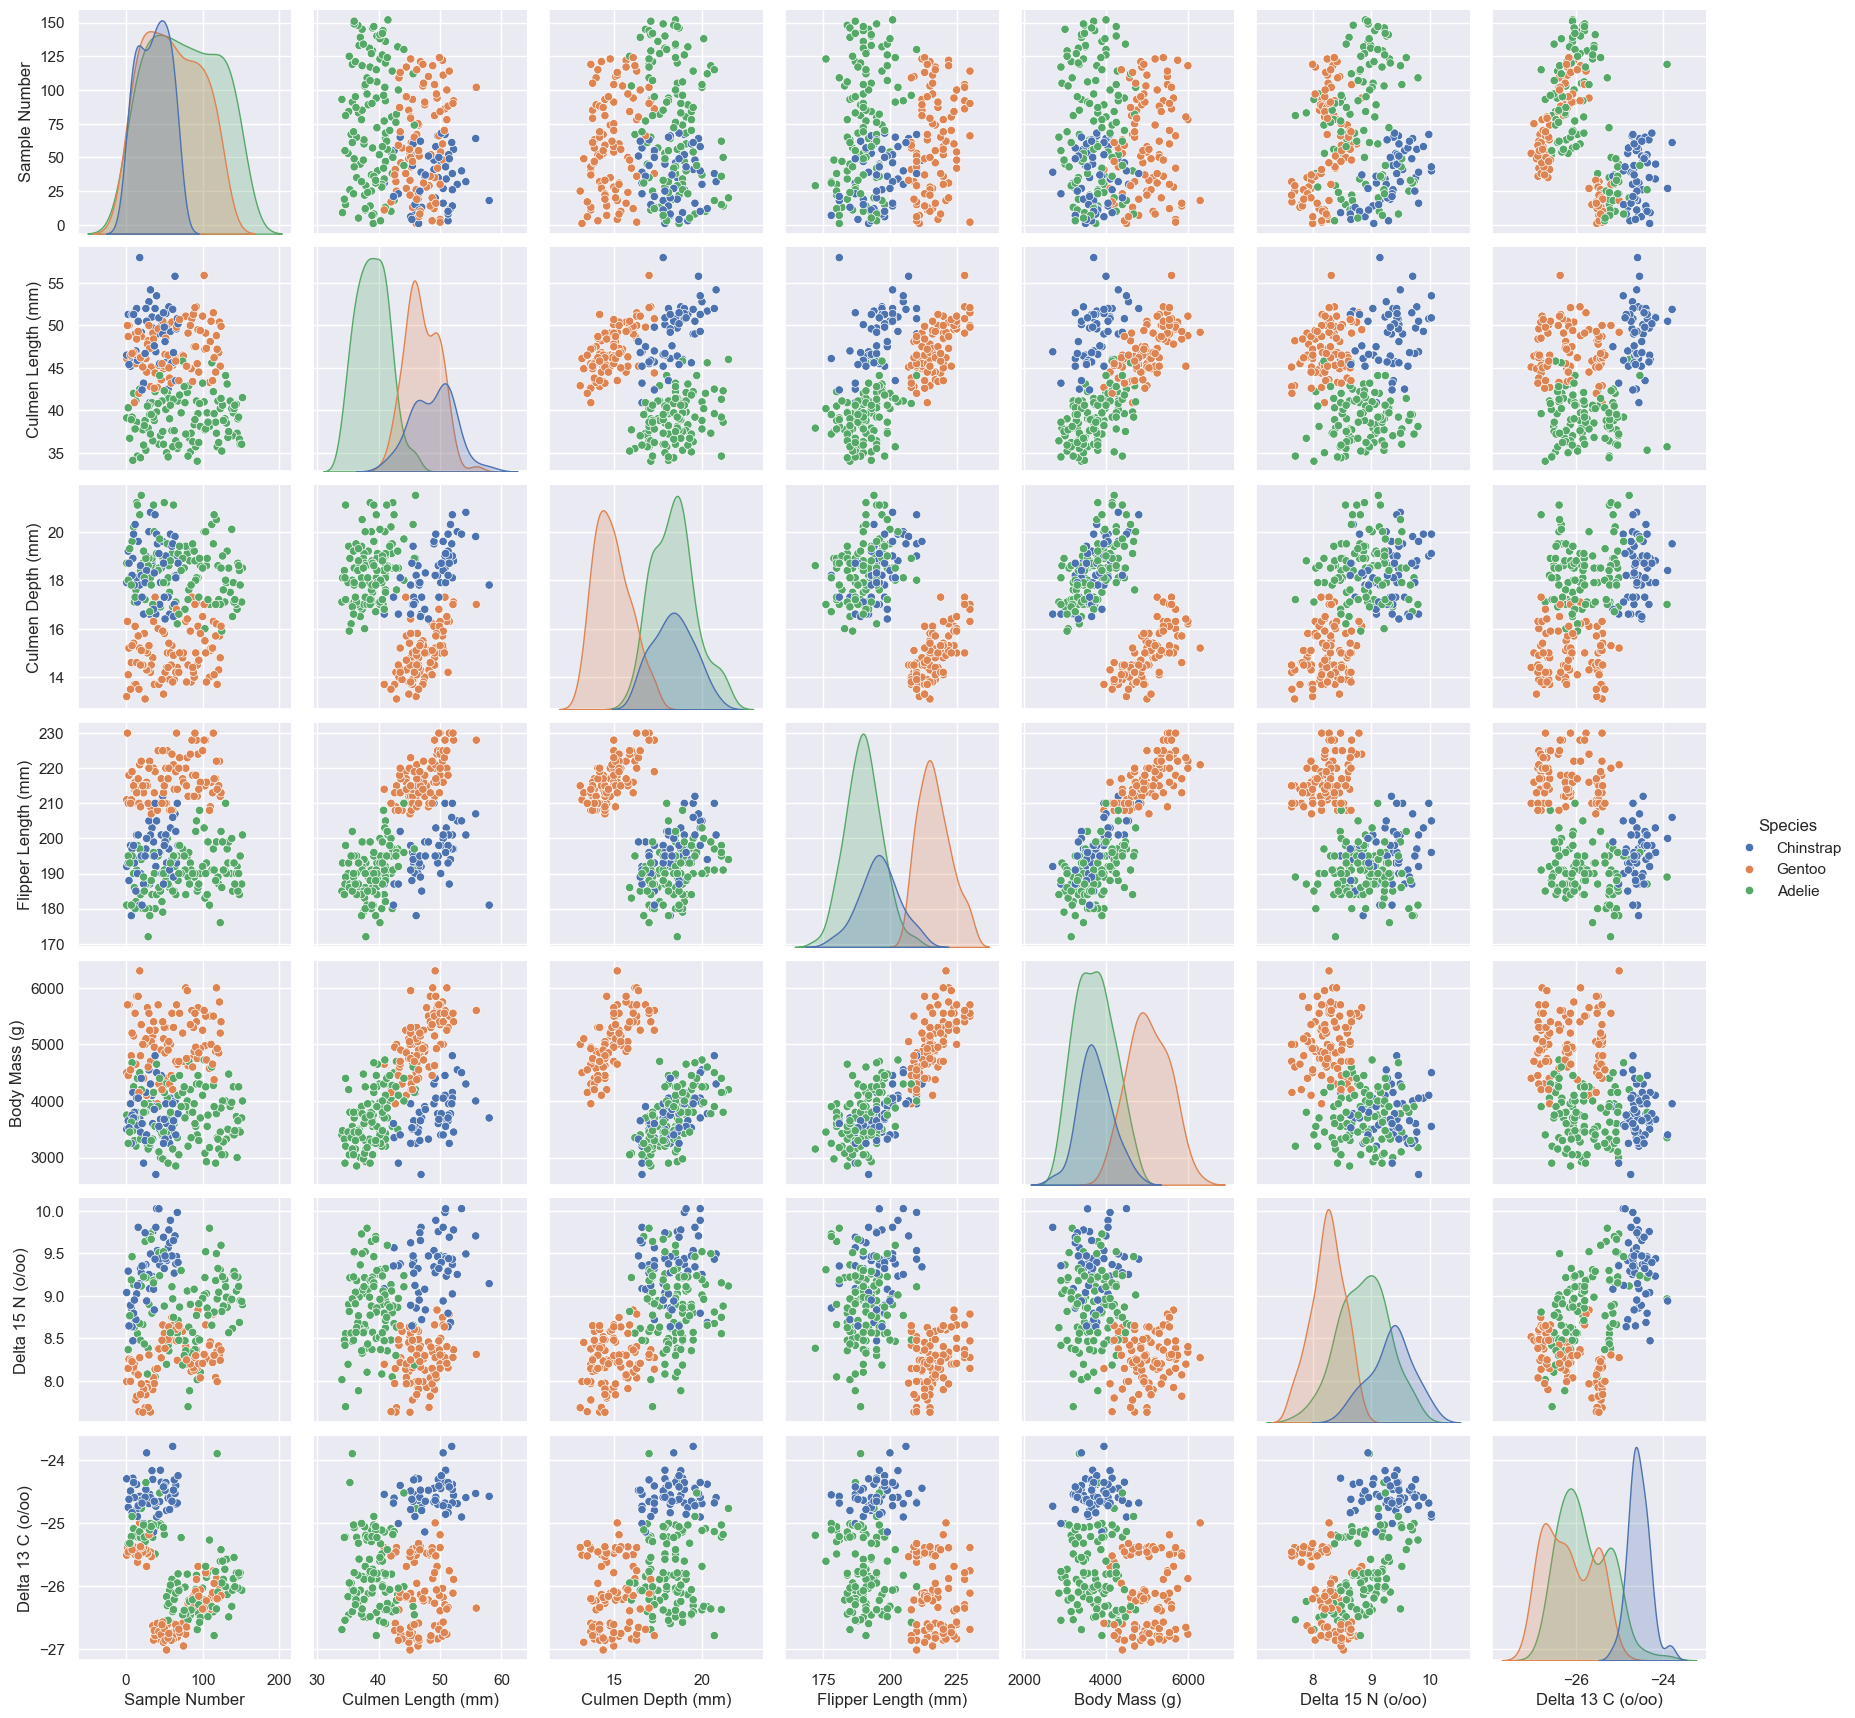

In [134]:
import seaborn as sns
sns.set_theme()
sns.pairplot(data=train, hue="Species")

I scanned the above plot for data pairs that I thought showed promise in indicating species differentiation.

Here is the relationship between Culmen Length (mm) and Culmen Depth (mm):

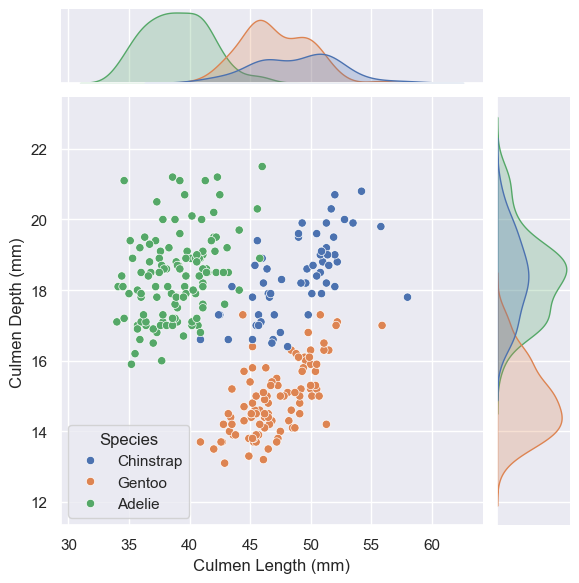

In [135]:
sns.jointplot(data = train, x = "Culmen Length (mm)", y = "Culmen Depth (mm)", hue = "Species")

We can see that the three species of Penguins fall into three more or less distinct regions of the scatter plot with minimal overlap. This suggests that Culmen Length and Culmen Depth could be good points of reference when training a classification model.

Below is a plot that demonstrates the relationship between Gender, Flipper Length, and Body Mass:

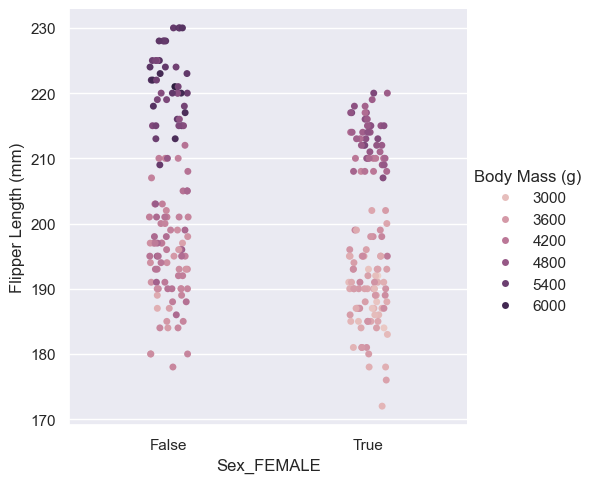

In [136]:
sns.catplot(data = X_train, x = "Sex_FEMALE", y = "Flipper Length (mm)", hue = "Body Mass (g)")

The above plot shows us that flipper length and body mass are positively correlated. In addition, we see that Males penguins have a higher growth ceiling in terms of body mass and flipper length.

The figure below illustrated some interesting data pertaining to species distribution over the islands. In addition, it gives us insight on the flipper length by species.

In [137]:
import numpy as np
train.groupby(["Island", "Species"])["Flipper Length (mm)"].agg(mean_flipper_length_mm="mean", std_flipper_length_mm="std")

mean_flipper_length_mm  std_flipper_length_mm
Island    Species                                                 
Biscoe    Adelie                 188.636364               6.570855
          Gentoo                 216.752577               5.933715
Dream     Adelie                 190.133333               6.780989
          Chinstrap              196.000000               7.423419
Torgersen Adelie                 191.195122               6.626536

We can observe that not every species is found on every island. The Adelie Penguin the only penguin found on all three surveyed islands. The Gentoo penguin is found exclusively on Biscoe Island and the Chinstrap penguin is found exclusively on Dream Island. In addition, the Gentoo penguins have the largest and least variable mean flipper length. They are followed by the Chinstrap penguins in size, then the Adelie with the smallest mean flipper lengths. Adelie and Chinstrap flipper lengths may overlap quite a bit, potentially making flipper length an unreliable feature for classifying the two species.

# Model Training

In the following we will employ a Logistic Regression model to classify our penguins. An integral step is figuring out which features we want to use to train our model. My methodology for this is a the brute force approach of testing out all the possible combinations using the handy `combinations` tool. The combinations tool will be used in conjunction with the `cross_val_score` tool from `sklearn` that will cross validate to avoid overfitting to the data. This step will help us perform better on data that the model has never seen before.

*After encountering maximum iteration issues with the logistic regression model, I scaled the data with the `StandardScaler` to be more manageable for the model*

In [138]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

LR = LogisticRegression()
scaler = StandardScaler()

X_train[all_quant_cols] = scaler.fit_transform(X_train[all_quant_cols])
score = 0
final_cols = []


for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    LR.fit(X_train[cols], y_train)
    cross_val_scores = cross_val_score(LR, X_train[cols], y_train, cv = 10)
    if cross_val_scores.mean() > score:
      score = cross_val_scores.mean()
      final_cols = cols

print(f"The best model scored {score*100}% accuracy when testing on training data using: \n{final_cols}")    


The best model scored 99.21538461538461% accuracy when testing on training data using: 
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)']


Now we have a repeatable, quantitative approach to justify training our model on the following features: **Island, Culmen Length (mm), Culmen Depth (mm)**

*I rearrange `final_cols` below to lead with quantitative features to conform to the graphing parameters that I will present later*

In [139]:
final_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']

LR = LogisticRegression()
LR.fit(X_train[final_cols], y_train)
LR.score(X_train[final_cols], y_train)

0.99609375

Our model performed with ~99% accuracy when using our selected three features and testing on our training data. This validates some of our visual predictions we identified in our exploration section. This is a great accuracy to have... however we are still testing our model on the data it was trained with. Next we will test it against unseen data!

In [140]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

test["Species"] = test["Species"].str.split().str.get(0)

X_test, y_test = prepare_data(test)
X_test[all_quant_cols] = scaler.fit_transform(X_test[all_quant_cols])

LR.score(X_test[final_cols], y_test)

1.0

Wow! We achieved an **100% testing accuracy** on our test data! In context, we were able to correctly classify what type of penguin an individual was based on what island they were on and their culmen length and depth.

# Evaluation

The following block sets up a plot panel of decision regions that represent our classifier.

In [141]:
from matplotlib import pyplot as plt

In [142]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (9, 4))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

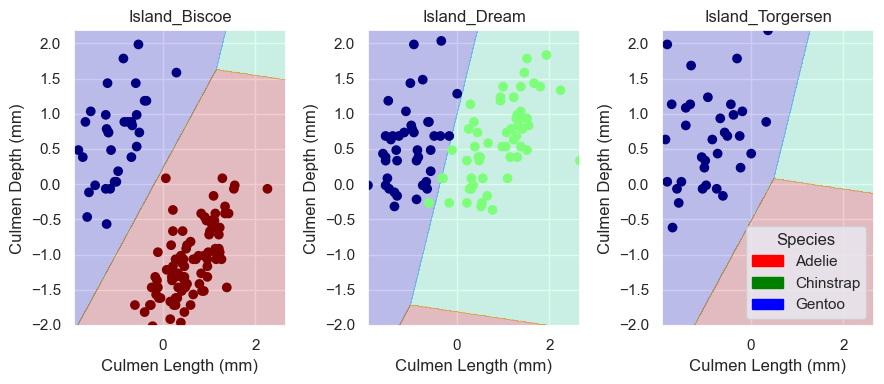

In [143]:
plot_regions(LR, X_train[final_cols], y_train)

As we noted in our exploration, not all penguins are found on all islands. This mean that our model essentially only had to account for a maximum of two species of penguins on any given island. we can see that the Culmen Length and Depth were also clustered nicely to have clear linear segmentation for our decision regions. 

Lets take a look at our confusion matrix:

In [144]:
from sklearn.metrics import confusion_matrix

y_test_pred = LR.predict(X_test[final_cols])
C = confusion_matrix(y_test, y_test_pred)
C

array([[31,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 26]])

As we had a 100% testing accuracy, this is exactly the sort of confusion matrix we would expect. The diagonal representing our correct classifications. Above and below the diagonal are empty because we did not misclassify any penguins.

Here is another way to digest the confusion matrix:

In [145]:
for i in range(3):
    for j in range(3):
        print(f"There were {C[i,j]} {le.classes_[i]} penguins who were classified as {le.classes_[j]}.")

There were 31 Adelie penguins who were classified as Adelie.
There were 0 Adelie penguins who were classified as Chinstrap.
There were 0 Adelie penguins who were classified as Gentoo.
There were 0 Chinstrap penguins who were classified as Adelie.
There were 11 Chinstrap penguins who were classified as Chinstrap.
There were 0 Chinstrap penguins who were classified as Gentoo.
There were 0 Gentoo penguins who were classified as Adelie.
There were 0 Gentoo penguins who were classified as Chinstrap.
There were 26 Gentoo penguins who were classified as Gentoo.


# Discussion

Exploring the Palmer Penguins data is a great introduction to data analysis and machine learning. Our results highlighted the effectiveness of using Culmen Depth, Culmen Length and Island Location as predictive features to train a Logistic regression model. We began by exploring the data set. We set up a series of plots and tables that helped us contextualize the data and make predictions about which features of the data may be helpful. While this was useful for understanding the data we were working with, we needed a repeatable method for choosing our eventual three features. We then turned to training and testing logistic regression models on different feature combinations. We scored each combination with how it performed against the training data and was cross validated against smaller subsets of the data to avoid overfitting. Finally we used the cross validated features with the largest accuracy and tested them against a separate test data set. Here we achieved the desired **100% testing accuracy**. Finally, we took a moment to evaluate these results by examining the decision regions, and looking at the confusion matrix. Visualizing decision regions highlighted how well logistic regression can separate species based on our selected features. The confusion matrix confirmed the reliability of our model as there were no misclassifications. This blog gave me good insight on data analysis and practical machine learning workflows. Several important takeaways were the importance of separating our training and testing data to ensure our model works on unseen data. The importance of cross validation is also key to not overfitting our data.